# Project 3: Reddit API

## Problem Statement

To use data scrapped from reddit and create a model that is able to alert us of troll posts(that should be on r/Jokes) instead of r/askscience.

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from PIL import Image
from wordcloud import ImageColorGenerator, WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score



%matplotlib inline

## Data Cleaning

In [2]:
# importing our dataset csv

reddit_df = pd.read_csv('./reddit.csv')

In [3]:
reddit_df.head()

,Unnamed: 0,title,selftext,subreddit
0,0,r/jokes has a discord and you need to join!,Over 10k members! Come see reposts in real ti...,Jokes
1,1,"When I was a kid, Santa gave me a lump of coal...",Somehow the bastard found out and killed my dad.,Jokes
2,2,A son walks in on his parents having sex NSFW,The parents see the boy and he runs off to his...,Jokes
3,3,[NSFW] A doctor is giving a tour of a local ho...,One day a public health official goes to visit...,Jokes
4,4,Genie: You have 3 wishes.,Me: I've seen this before. Whatever I wish for...,Jokes


In [4]:
# Deleting column 'Unnamed: 0'.

reddit_df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
reddit_df.head()

,title,selftext,subreddit
0,r/jokes has a discord and you need to join!,Over 10k members! Come see reposts in real ti...,Jokes
1,"When I was a kid, Santa gave me a lump of coal...",Somehow the bastard found out and killed my dad.,Jokes
2,A son walks in on his parents having sex NSFW,The parents see the boy and he runs off to his...,Jokes
3,[NSFW] A doctor is giving a tour of a local ho...,One day a public health official goes to visit...,Jokes
4,Genie: You have 3 wishes.,Me: I've seen this before. Whatever I wish for...,Jokes


In [6]:
# Checking for null values
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 3 columns):
title        1984 non-null object
selftext     1668 non-null object
subreddit    1984 non-null object
dtypes: object(3)
memory usage: 46.6+ KB


In [7]:
# Replacing null values with empty string
reddit_df.fillna('', inplace=True)

In [8]:
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 3 columns):
title        1984 non-null object
selftext     1984 non-null object
subreddit    1984 non-null object
dtypes: object(3)
memory usage: 46.6+ KB


In [9]:
# changing our subreddit column to binary so that we can use it for our classification models.
# Since we want to be alerted of posts that do not belong to r/askscience, we will indicate askscience as 0.
# Therefore, 1 for jokes, 0 for askscience.
reddit_df['subreddit'] = reddit_df['subreddit'].map({'Jokes':1,'askscience':0})

In [10]:
# checking to see the distribution of our data. With roughly 1000 posts from each subreddit, they seem farely
# balanced.
reddit_df['subreddit'].value_counts()

0    1000
1     984
Name: subreddit, dtype: int64

In [11]:
# checking to see if there are any duplicated posts based on the same title.
reddit_df['title'].value_counts()

Knock knock                                                                    5
I went to the doctors recently                                                 3
I said to my doctor I might have ADHD.                                         2
Whats a similarity between Dale Earnhardt and Pink Floyd?                      2
[NSFW] Why don't any of Logan Paul's asian fans ask for high fives anymore?    2
                                                                              ..
What do you call a Mexican man with a rubber toe?                              1
Would death by nuclear explosion be painful? How painful?                      1
How do asexual organisms get the genetic variation necessary for evolution?    1
There is a dirty chicken......                                                 1
Is it possible for asteroids to contain incredibly huge gemstone cores?        1
Name: title, Length: 1876, dtype: int64

In [12]:
# combining the title and selftext column to a single column and then checking if there are still duplicates.
# Reason for this is because for example knock knock jokes might have the same title, but the joke which is in 
# selftext might be different, therefore we should also take into acocunt the selftext to determine if the post
# is truly a duplicate.

reddit_df['text'] = reddit_df['title'] + ' ' + reddit_df['selftext']

reddit_df['text'].head()

0    r/jokes has a discord and you need to join! Ov...
1    When I was a kid, Santa gave me a lump of coal...
2    A son walks in on his parents having sex NSFW ...
3    [NSFW] A doctor is giving a tour of a local ho...
4    Genie: You have 3 wishes. Me: I've seen this b...
Name: text, dtype: object

In [13]:
reddit_df['text'].value_counts() > 1

Genie: You have 3 wishes. Me: I've seen this before. Whatever I wish for will come back and bite me in some way.\n\nGenie: I promise that won't happen. I'm so sure it won't I'll give you infinite wishes if it does.\n\nMe: Okay. I wish for a boomerang with teeth.\n\nGenie: You son of a...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [14]:
# Seeing that there are still duplicates after taking into account the selftext, we should then proceed to remove
# these duplicates as they might influence/ impact our model.

reddit_df.drop_duplicates(subset='text', keep='last', inplace=True)

reddit_df['text'].value_counts()

What Aleph number describes the cardinality of the set of Aleph numbers? That is, are the number of Aleph numbers countably or uncountable infinite? Thanks :-)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [15]:
# checking to see if our distribution of data is still fairly balanced
reddit_df['subreddit'].value_counts()

0    998
1    883
Name: subreddit, dtype: int64

In [16]:
# Looking at the texts above, it seems there are quite a lot of formatting characters such as '\n'. Let us remove
# them.
reddit_df['title'].replace(r'\n',' ', regex=True, inplace=True)
reddit_df['selftext'].replace(r'\n',' ', regex=True, inplace=True)
reddit_df['text'].replace(r'\n',' ', regex=True, inplace=True)

## Exploratory Data Analysis

Now that we have cleaned up duplicate threads from our data, we are going to explore our data a little further and see what insights we can get from it. As this project is dealing with unstructured data, the EDA is a little bit different.

Some of the EDA we could look into:
1. Word count of title.
2. Word count of selftext.
3. Most frequent words.

In [17]:
# Creating a function to tokenize and lemmatize our data .
def text_breakdown(text):

    # Instantiate tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    
    # Tokenize text.
    tokens_before_stop = tokenizer.tokenize(text.lower())
    
    # Removing stopwords from tokenized text
    tokens = [w for w in tokens_before_stop if not w in stopwords.words('english')]
    
    # Instantiate lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize words
    lemmatized_tokens = [lemmatizer.lemmatize(i) for i in tokens]
    
    # Converting the list into a string
    str1 = ''
    for word in lemmatized_tokens:
        str1 = str1 + ' ' + word
    
    return str1

In [18]:
# Creating a column where we tokenize and lemmatize our text column
reddit_df['lemmatized_text'] = reddit_df['text'].map(text_breakdown)

reddit_df['lemmatized_text'][:5]

101     asshole call person put punchline joke title
102                        call ape fetish kink kong
103                          body temple mostly ruin
104              call mexican man rubber toe roberto
105                          cloud like wear rainbow
Name: lemmatized_text, dtype: object

### Train / Test Split

The reason for splitting the data at this point of the project is because I want to only be exploring the training data, which we would be training the model with. The test/validation data is for us to validate if decisions made regarding to the model was good, therefore we don't want to be exploring the test/validation data, but instead use it to validate our decisions made with the training data.

In [19]:
X = reddit_df.lemmatized_text
y = reddit_df.subreddit

In [20]:
# Splitting our data into train and test set with stratify so that we get an equal balance of each class
# for each set of data.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

### Visualization

In [21]:
# Getting the index of the training data so we can apply to the main data set and do some visualizations with 
# the training data
training_data_index = X_train.index.values

reddit_df_train = reddit_df.loc[training_data_index,:]

In [22]:
reddit_df_train.head()

,title,selftext,subreddit,text,lemmatized_text
1972,Are there any 2 species alive today that share...,,0,Are there any 2 species alive today that share...,2 specie alive today share common ancestor sp...
1105,Why does choked flow happen and why it is rela...,I'm diving into the venturi effect (example: r...,0,Why does choked flow happen and why it is rela...,choked flow happen related speed sound diving...
1250,"How come when you cook an egg, it gets harder,...",,0,"How come when you cook an egg, it gets harder,...",come cook egg get harder cook vegetable get s...
1945,What causes this coast line shape?,All down the eastern coast of Australia (and p...,0,What causes this coast line shape? All down th...,cause coast line shape eastern coast australi...
347,Helium walks into a bar,He sits and order a drink while wondering why ...,1,Helium walks into a bar He sits and order a dr...,helium walk bar sits order drink wondering pa...


In [23]:
cvec = CountVectorizer(max_features=100, stop_words='english')

lemmatized_text_cvec = cvec.fit_transform(reddit_df_train['lemmatized_text'])
top_words = cvec.get_feature_names()

Text(0, 0.5, 'Frequency Count')

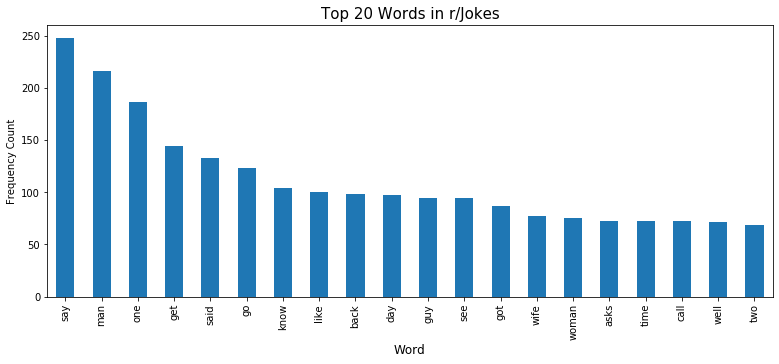

In [24]:
# Top 20 words in r/Jokes
jokes_top_words = reddit_df[reddit_df['subreddit']==1]['lemmatized_text'].str.split(expand=True).stack().value_counts()[:20]

plt.figure(figsize=(13,5))
jokes_top_words.plot(kind='bar')
plt.title('Top 20 Words in r/Jokes', size=15)
plt.xlabel('Word', size=12)
plt.ylabel('Frequency Count')

Text(0, 0.5, 'Frequency Count')

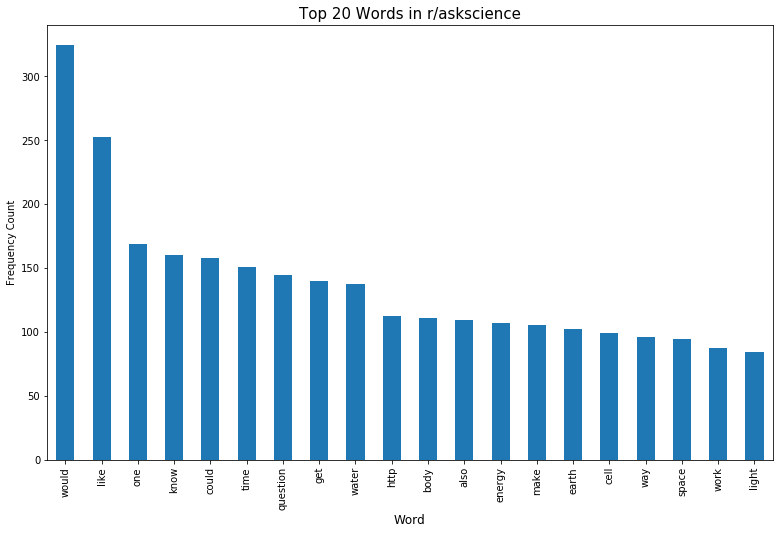

In [25]:
# Top 20 words in r/askscience
askscience_top_words = reddit_df[reddit_df['subreddit']==0]['lemmatized_text'].str.split(expand=True).stack().value_counts()[:20]

plt.figure(figsize=(13,8))
askscience_top_words.plot(kind='bar')
plt.title('Top 20 Words in r/askscience', size=15)
plt.xlabel('Word', size=12)
plt.ylabel('Frequency Count')

In [26]:
top_words_string = ''
for word in top_words:
    top_words_string = top_words_string+ ' ' +word

In [27]:
# As can be seen, lemmatizing has not been very helpful as there are still 3 instances of ask -> ask, asked and
# asks, but at least it is still better than stemming the word as stemming might sometimes cause the word to
# become incomprehensible.
top_words_string

' able actually air amp animal answer ask asked asks away bar better black blood body boy brain cause cell change com come day different earth effect energy exactly example field friend going good got guy hand head help high hole http human increase know level life light like little long look make man mass matter mean need new number old people place point possible pressure question really reply right said say science second sound space specie star start state sure tell temperature thing think time tree turn understand universe use used walk want water way wife woman work www year'

In [28]:
# Importing image to create a mask for word cloud
char_mask_reddit = np.array(Image.open("./reddit-logo2.jpg"))
image_colors_reddit = ImageColorGenerator(char_mask_reddit)

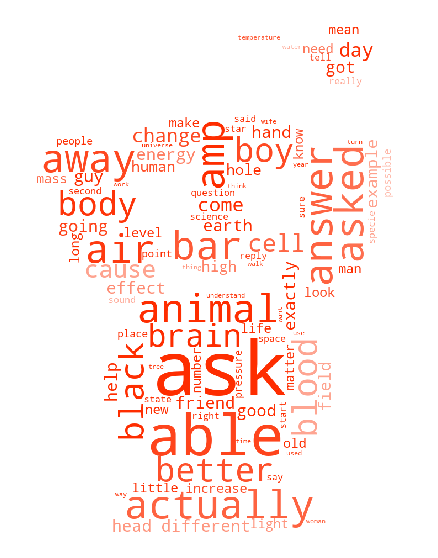

In [29]:
# Plotting word cloud featuring the most common words in our dataset. Question is, how are we able to determine
# which are the keywords for their respective subreddit?
plt.subplots(figsize=(10,10)) # setting figure size
plt.axis('off') # turning off axis
plt.grid(b=None) # turning off grid

wc_reddit = WordCloud(background_color="white", 
               max_words=100, 
               mask=char_mask_reddit, 
               random_state=1).generate(top_words_string)

plt.imshow(wc_reddit.recolor(color_func=image_colors_reddit))

In [30]:
# Saving world cloud
wc_reddit.to_file('./reddit-word.png')

In [31]:
# Creating our columns for the word count of the titles. Will be replacing formatting characters such as '\n' with
# empty space before we count the length.

reddit_title = reddit_df_train['title'].replace('\n',' ')
reddit_df_train['title_length'] = reddit_title.map(lambda x: len(str(x).split(' ')))

In [32]:
reddit_df_train.head()

,title,selftext,subreddit,text,lemmatized_text,title_length
1972,Are there any 2 species alive today that share...,,0,Are there any 2 species alive today that share...,2 specie alive today share common ancestor sp...,18
1105,Why does choked flow happen and why it is rela...,I'm diving into the venturi effect (example: r...,0,Why does choked flow happen and why it is rela...,choked flow happen related speed sound diving...,16
1250,"How come when you cook an egg, it gets harder,...",,0,"How come when you cook an egg, it gets harder,...",come cook egg get harder cook vegetable get s...,18
1945,What causes this coast line shape?,All down the eastern coast of Australia (and p...,0,What causes this coast line shape? All down th...,cause coast line shape eastern coast australi...,6
347,Helium walks into a bar,He sits and order a drink while wondering why ...,1,Helium walks into a bar He sits and order a dr...,helium walk bar sits order drink wondering pa...,5


In [33]:
# As we did for the title column, now to create a column for the word count of the selftext column.

reddit_selftext = reddit_df_train['selftext'].replace('\n',' ')
reddit_df_train['selftext_length'] = reddit_selftext.map(lambda x: len(str(x).split(' ')))

In [34]:
reddit_df_train.head()

,title,selftext,subreddit,text,lemmatized_text,title_length,selftext_length
1972,Are there any 2 species alive today that share...,,0,Are there any 2 species alive today that share...,2 specie alive today share common ancestor sp...,18,1
1105,Why does choked flow happen and why it is rela...,I'm diving into the venturi effect (example: r...,0,Why does choked flow happen and why it is rela...,choked flow happen related speed sound diving...,16,42
1250,"How come when you cook an egg, it gets harder,...",,0,"How come when you cook an egg, it gets harder,...",come cook egg get harder cook vegetable get s...,18,1
1945,What causes this coast line shape?,All down the eastern coast of Australia (and p...,0,What causes this coast line shape? All down th...,cause coast line shape eastern coast australi...,6,88
347,Helium walks into a bar,He sits and order a drink while wondering why ...,1,Helium walks into a bar He sits and order a dr...,helium walk bar sits order drink wondering pa...,5,28


Text(0.5, 0, 'Number of words')

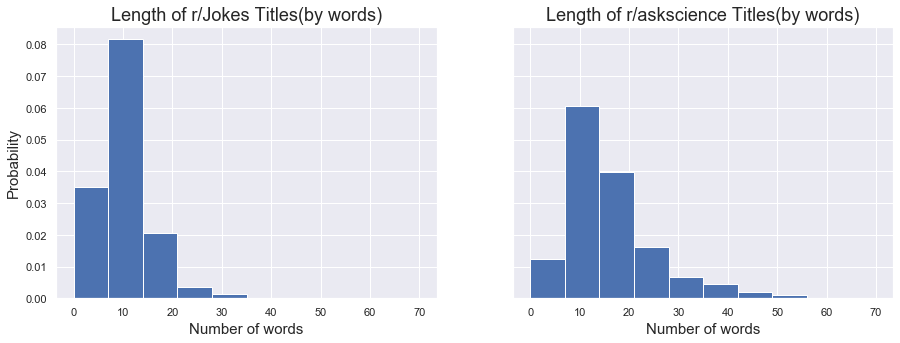

In [35]:
# plotting histogram to see distribution of title length based on words for the respective subreddits
sns.set()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=True)

ax[0].hist(reddit_df_train[reddit_df_train['subreddit']==1]['title_length'], range=(0,70), density=True)
ax[0].set_title('Length of r/Jokes Titles(by words)', fontsize=18)
ax[0].set_xlabel('Number of words', fontsize=15)
ax[0].set_ylabel('Probability', fontsize=15)

ax[1].hist(reddit_df_train[reddit_df_train['subreddit']==0]['title_length'], range=(0,70), density=True)
ax[1].set_title('Length of r/askscience Titles(by words)', fontsize=18)
ax[1].set_xlabel('Number of words', fontsize=15)

Text(0.5, 0, 'Number of words')

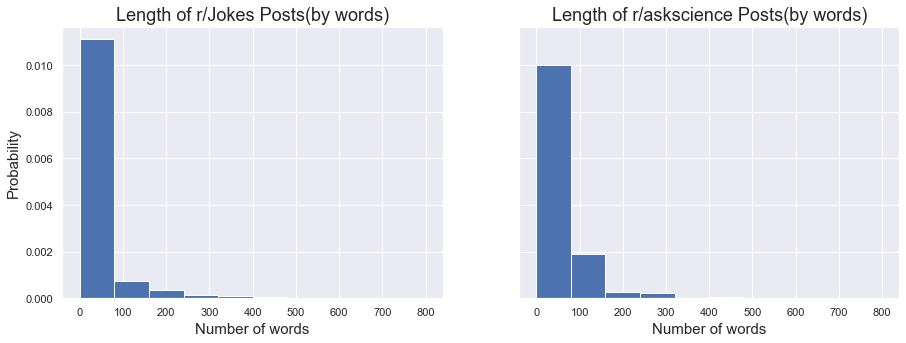

In [36]:
# plotting histogram to see distribution of selftext length based on words for the respective subreddits
sns.set()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=True, sharey=True)

ax[0].hist(reddit_df_train[reddit_df_train['subreddit']==1]['selftext_length'], range=(0,800), density=True)
ax[0].set_title('Length of r/Jokes Posts(by words)', fontsize=18)
ax[0].set_xlabel('Number of words', fontsize=15)
ax[0].set_ylabel('Probability', fontsize=15)

ax[1].hist(reddit_df_train[reddit_df_train['subreddit']==0]['selftext_length'], range=(0,800), density=True)
ax[1].set_title('Length of r/askscience Posts(by words)', fontsize=18)
ax[1].set_xlabel('Number of words', fontsize=15)

Observation:

Based on the graphs above, it seems that r/askscience generally have longer titles and posts(selftext) compared to r/Jokes. This might make sense as you would think generally when someone posts on r/askscience, he/she is trying to understand a concept and thus have a longer post trying to relay whatever informatation it is that they are trying to understand.

## Modelling & Evaluation

### Baseline

In [37]:
# Baseline score 0.469431
reddit_df['subreddit'].value_counts(normalize=True)

0    0.530569
1    0.469431
Name: subreddit, dtype: float64

### Multinomial Naive Bayes (Count Vectorizer)

In [38]:
# Creating an instance of a pipeline, consisting of a vectorizer and our model.
nbcvec_pipe = Pipeline([("cvec", CountVectorizer()),
                   ("mn_model", MultinomialNB())
                   ])

In [39]:
# Looking at the hyperparameters so that we can decide which are the ones we want to run through GridSearchCV to
# optimize the model.
nbcvec_pipe.steps

[('cvec', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                  lowercase=True, max_df=1.0, max_features=None, min_df=1,
                  ngram_range=(1, 1), preprocessor=None, stop_words=None,
                  strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, vocabulary=None)),
 ('mn_model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

In [40]:
# Performing GridSearch CV to determine the best hyperparameters
nbcvec_pipe_params = {'cvec__max_features': [1000, 1200, 1400],
                  'cvec__min_df': [2, 4, 6],
                  'cvec__max_df': [.1, .2, .3],
                  'cvec__ngram_range': [(1,1), (1,2)],
                  'mn_model__alpha': [0.5, 0.6, 0.7]
                 }

nbcvec_gs = GridSearchCV(nbcvec_pipe, param_grid=nbcvec_pipe_params, cv=5, n_jobs=-1)
nbcvec_gs.fit(X_train, y_train)
print(nbcvec_gs.best_score_)
print(nbcvec_gs.best_params_)

0.898581560283688
{'cvec__max_df': 0.2, 'cvec__max_features': 1200, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 1), 'mn_model__alpha': 0.5}


In [41]:
# mean score of our GridSearch CV
nbcvec_gs.cv_results_['mean_test_score'].mean()

0.890942124157254

In [42]:
# applying the best params to our model
nbcvec_pipe_tuned = Pipeline([("cvec", CountVectorizer(max_df=0.2,
                                                   max_features=1200,
                                                   min_df=4,
                                                   ngram_range=(1,1))),
                         ("mn_model", MultinomialNB(alpha=0.5))
                          ])

In [43]:
#fitting tuned model with with training data.
nbcvec_pipe_tuned.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.2,
                                 max_features=1200, min_df=4,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('mn_model',
                 MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True))],
         verbose=False)

In [44]:
nbcvec_pipe_tuned.score(X_train, y_train)

0.9283687943262411

In [45]:
nbcvec_pipe_tuned.score(X_test, y_test)

0.89171974522293

In [46]:
# predictions for test data using naive bayes model
nbcvec_predictions = nbcvec_pipe_tuned.predict(X_test)

In [47]:
# confusion matrix for our naive bayes model
nbcvec_confusion_matrix = confusion_matrix(y_test, nbcvec_predictions)

In [48]:
nbcvec_confusion_matrix

array([[232,  18],
       [ 33, 188]])

In [49]:
# confusion matrix for our naive bayes model with count vectorizer
tn, fp, fn, tp = nbcvec_confusion_matrix.ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 232
False Positives: 18
False Negatives: 33
True Positives: 188


In [50]:
# Calculating our metrics for our naive bayes model with count vectorizer
nbcvec_acc = round((tp+tn)/(tn+fp+fn+tp),4)
nbcvec_sensi = round(tp/(tp+fn),4)
nbcvec_spec = round(tn/(tn+fp),4)
nbcvec_prec = round(tp/(tp+fp),4)

print(f'Accuracy: {nbcvec_acc}')
print(f'Sensitivity: {nbcvec_sensi}')
print(f'Specificity: {nbcvec_spec}')
print(f'Precision: {nbcvec_prec}')

Accuracy: 0.8917
Sensitivity: 0.8507
Specificity: 0.928
Precision: 0.9126


In [51]:
# Creating a list of metrics for summary later on
nbcvec_metrics = [nbcvec_acc, nbcvec_sensi, nbcvec_spec, nbcvec_prec]

Text(0.5, 12.5, 'Predicted Values')

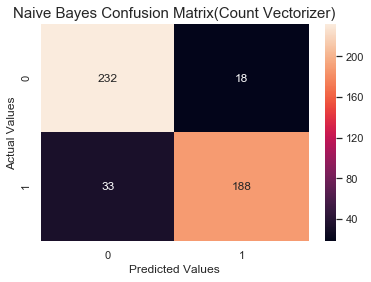

In [52]:
# Plotting the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(nbcvec_confusion_matrix, annot=True, fmt='g')
bottom, top= ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Naive Bayes Confusion Matrix(Count Vectorizer)', size=15)
ax.set_ylabel('Actual Values', size=12)
ax.set_xlabel('Predicted Values', size=12)

In [53]:
# Creating a function to plot roc curve
def roc(probas, true, step=0.01):
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i 
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
    
    # Plot ROC curve.
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.plot(FPRs, # False Positive Rate on X-axis
             TPRs, # True Positive Rate on Y-axis
             label='ROC Curve')

    # Plot baseline. (Perfect overlap between the two populations.)
    plt.plot(np.linspace(0, 1, 200),
             np.linspace(0, 1, 200),
             label='baseline',
             linestyle='--')

    # Label axes.
    plt.title('Receiver Operating Characteristic Curve', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18)
    plt.xlabel('1 - Specificity', fontsize=18)
    
    # Create legend.
    plt.legend(fontsize=16);

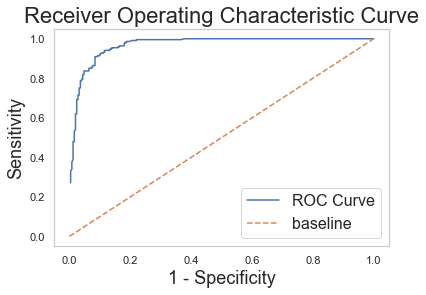

In [54]:
# Plotting ROC curve for naive bayes model with count vectorizer
nbcvec_probabilities = nbcvec_pipe_tuned.predict_proba(X_test)

roc(probas = nbcvec_probabilities,
   true = y_test,
   step = 0.0001)

In [55]:
# AUC score for our ROC Curve
pred_proba = [i[1] for i in nbcvec_pipe_tuned.predict_proba(X_test)]
nbcvec_auc = roc_auc_score(y_test, pred_proba)

print(nbcvec_auc)

0.9685067873303167


### Multinomial Naive Bayes(TF-IDF Vectorizer)

In [56]:
# Creating an instance of a pipeline, consisting of a vectorizer and our model.
nbtfidf_pipe = Pipeline([("tvec", TfidfVectorizer()),
                   ("mn_model", MultinomialNB())
                   ])

In [57]:
# Looking at the hyperparameters so that we can decide which are the ones we want to run through GridSearchCV to
# optimize the model.
nbtfidf_pipe.steps

[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.0, max_features=None,
                  min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                  smooth_idf=True, stop_words=None, strip_accents=None,
                  sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, use_idf=True, vocabulary=None)),
 ('mn_model', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]

In [58]:
# Performing GridSearch CV to determine the best hyperparameters
nbtfidf_pipe_params = {'tvec__max_features': [1200, 1400, 1600],
                  'tvec__min_df': [1, 2, 3],
                  'tvec__max_df': [.1, .2, .3],
                  'tvec__ngram_range': [(1,1), (1,2)],
                  'mn_model__alpha': [0.5, 0.6, 0.7]
                 }

nbtfidf_gs = GridSearchCV(nbtfidf_pipe, param_grid=nbtfidf_pipe_params, cv=5, n_jobs=-1)
nbtfidf_gs.fit(X_train, y_train)
print(nbtfidf_gs.best_score_)
print(nbtfidf_gs.best_params_)

0.9014184397163121
{'mn_model__alpha': 0.5, 'tvec__max_df': 0.2, 'tvec__max_features': 1400, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


In [59]:
# mean score of our GridSearch CV
nbtfidf_gs.cv_results_['mean_test_score'].mean()

0.8956396112424482

In [60]:
# applying the best params to our model
nbtfidf_pipe_tuned = Pipeline([("tvec", TfidfVectorizer(max_df=0.2,
                                                   max_features=1400,
                                                   min_df=2,
                                                   ngram_range=(1,2))),
                             ("mn_model", MultinomialNB(alpha=0.5))
                              ])

In [61]:
#fitting tuned model with with training data.
nbtfidf_pipe_tuned.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.2, max_features=1400,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('mn_model',
                 MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True))],
         verbose=False)

In [62]:
nbtfidf_pipe_tuned.score(X_train, y_train)

0.9524822695035461

In [63]:
nbtfidf_pipe_tuned.score(X_test, y_test)

0.9129511677282378

In [64]:
# predictions for test data using naive bayes model
nbtfidf_predictions = nbtfidf_pipe_tuned.predict(X_test)

In [65]:
# confusion matrix for our naive bayes model
nbtfidf_confusion_matrix = confusion_matrix(y_test, nbtfidf_predictions)

In [66]:
nbtfidf_confusion_matrix

array([[234,  16],
       [ 25, 196]])

In [67]:
# confusion matrix for our naive bayes model
tn, fp, fn, tp = nbtfidf_confusion_matrix.ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 234
False Positives: 16
False Negatives: 25
True Positives: 196


In [68]:
# Calculating our metrics for our naive bayes model with tf-idf vectorizer
nbtfidf_acc = round((tp+tn)/(tn+fp+fn+tp),4)
nbtfidf_sensi = round(tp/(tp+fn),4)
nbtfidf_spec = round(tn/(tn+fp),4)
nbtfidf_prec = round(tp/(tp+fp),4)

print(f'Accuracy: {nbtfidf_acc}')
print(f'Sensitivity: {nbtfidf_sensi}')
print(f'Specificity: {nbtfidf_spec}')
print(f'Precision: {nbtfidf_prec}')

Accuracy: 0.913
Sensitivity: 0.8869
Specificity: 0.936
Precision: 0.9245


In [69]:
# Creating a list of metrics for summary later on
nbtfidf_metrics = [nbtfidf_acc, nbtfidf_sensi, nbtfidf_spec, nbtfidf_prec]

Text(0.5, 12.5, 'Predicted Values')

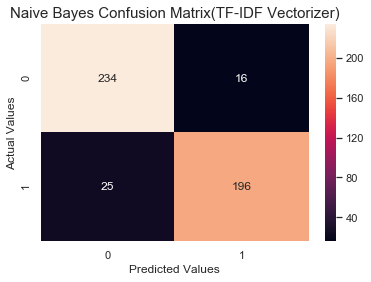

In [70]:
# Plotting the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(nbtfidf_confusion_matrix, annot=True, fmt='g')
bottom, top= ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Naive Bayes Confusion Matrix(TF-IDF Vectorizer)', size=15)
ax.set_ylabel('Actual Values', size=12)
ax.set_xlabel('Predicted Values', size=12)

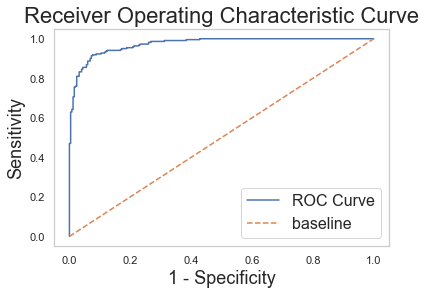

In [71]:
# Plotting ROC curve for naive bayes model with tf-idf vectorizer
nbtfidf_probabilities = nbtfidf_pipe_tuned.predict_proba(X_test)

roc(probas = nbtfidf_probabilities,
   true = y_test,
   step = 0.0001)

In [72]:
# AUC score for our ROC Curve
pred_proba = [i[1] for i in nbtfidf_pipe_tuned.predict_proba(X_test)]
nbtfidf_auc = roc_auc_score(y_test, pred_proba)

print(nbtfidf_auc)

0.9731402714932127


### Logistic Regression

In [73]:
# Creating an instance of our pipeline, which consists of our tfidf vectorizer and our logistic regression
lr_pipe = Pipeline([("tvec", TfidfVectorizer()),
                 ("lr", LogisticRegression())
                ])

In [74]:
# as can be seen, the following are the parameters of the tfidf vectorizer and logistice regression model that we
# will be using to classify our data.
lr_pipe.steps

[('tvec', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.0, max_features=None,
                  min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                  smooth_idf=True, stop_words=None, strip_accents=None,
                  sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=None, use_idf=True, vocabulary=None)),
 ('lr',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, solver='warn', tol=0.0001, verbose=0,
                     warm_start=False))]

In [75]:
# Performing GridSearch CV to determine the best hyperparameters
lr_pipe_params = {'tvec__max_features': [800, 1000, 1200],
               'tvec__min_df': [1, 2, 3],
               'tvec__max_df': [.1, .2, .3],
               'tvec__ngram_range': [(1,1), (1,2)],
                'lr__max_iter': [40, 60, 80],
                'lr__solver': ['newton-cg', 'lbfgs', 'liblinear']
              }

lr_gs = GridSearchCV(lr_pipe, param_grid=lr_pipe_params, cv=5, n_jobs=-1)
lr_gs.fit(X_train, y_train)
print(lr_gs.best_score_)
print(lr_gs.best_params_)

0.900709219858156
{'lr__max_iter': 40, 'lr__solver': 'newton-cg', 'tvec__max_df': 0.2, 'tvec__max_features': 1000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}


In [76]:
# mean score of our GridSearch CV
lr_gs.cv_results_['mean_test_score'].mean()

0.8940985903160844

In [77]:
# applying the best params to our logreg model
lr_pipe_tuned = Pipeline([("tvec",TfidfVectorizer(max_df=0.2,
                                                  min_df=2,
                                                  max_features=1000,
                                                  ngram_range=(1,2))),
                        ("lr",LogisticRegression(max_iter=40, solver='newton-cg'))
                       ])

In [78]:
# fitting tuned logistic regression model
lr_pipe_tuned.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tvec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.2, max_features=1000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1

In [79]:
lr_pipe_tuned.score(X_train, y_train)

0.9574468085106383

In [80]:
lr_pipe_tuned.score(X_test, y_test)

0.9129511677282378

In [81]:
# predictions for test data using logistic regression model.
lr_predictions = lr_pipe_tuned.predict(X_test)

In [82]:
# confusion matrix for logistic regression model
lr_confusion_matrix = confusion_matrix(y_test, lr_predictions)

In [83]:
lr_confusion_matrix

array([[236,  14],
       [ 27, 194]])

In [84]:
# confusion matrix for our naive bayes model
tn, fp, fn, tp = lr_confusion_matrix.ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 236
False Positives: 14
False Negatives: 27
True Positives: 194


In [85]:
# Calculating our metrics for our naive bayes model with count vectorizer
lr_acc = round((tp+tn)/(tn+fp+fn+tp),4)
lr_sensi = round(tp/(tp+fn),4)
lr_spec = round(tn/(tn+fp),4)
lr_prec = round(tp/(tp+fp),4)

print(f'Accuracy: {lr_acc}')
print(f'Sensitivity: {lr_sensi}')
print(f'Specificity: {lr_spec}')
print(f'Precision: {lr_prec}')

Accuracy: 0.913
Sensitivity: 0.8778
Specificity: 0.944
Precision: 0.9327


In [86]:
# Creating a list of metrics for summary later on
lr_metrics = [lr_acc, lr_sensi, lr_spec, lr_prec]

Text(0.5, 12.5, 'Predicted Values')

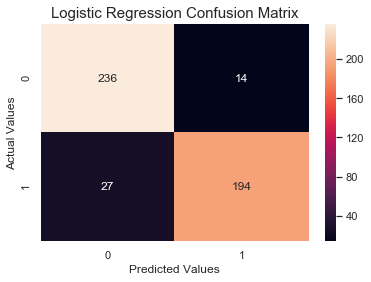

In [87]:
# Plotting the confusion matrix
fig, ax = plt.subplots()
sns.heatmap(lr_confusion_matrix, annot=True, fmt='g')
bottom, top= ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Logistic Regression Confusion Matrix', size=15)
ax.set_ylabel('Actual Values', size=12)
ax.set_xlabel('Predicted Values', size=12)

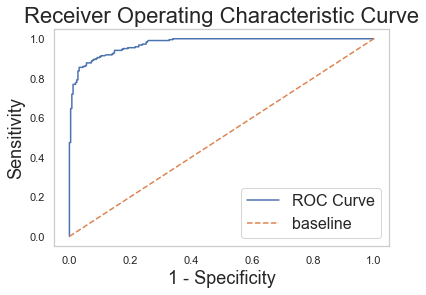

In [88]:
# Plotting ROC curve for logistic regression model with tf-idf vectorizer
lr_probabilities = lr_pipe_tuned.predict_proba(X_test)

roc(probas = lr_probabilities,
   true = y_test,
   step = 0.0001)

In [89]:
# AUC score for our ROC Curve
pred_proba = [i[1] for i in lr_pipe_tuned.predict_proba(X_test)]
lr_auc = roc_auc_score(y_test, pred_proba)

print(lr_auc)

0.9734751131221719


## Conclusion

In [90]:
# Creating a summary table of the results of our models
summary = pd.DataFrame({'NB(Count Vectorizer)': nbcvec_confusion_matrix.ravel(),
                        'NB (TF-IDF Vectorizer)': nbtfidf_confusion_matrix.ravel(),
                        'Logistic Regression': lr_confusion_matrix.ravel()},
                       
                    index = ['True Negatives',
                            'False Positives',
                            'False Negatives',
                            'True Positives'
                            ])

# Adding our metrics to the summary df
metrics_summary = pd.DataFrame({'NB(Count Vectorizer)': nbcvec_metrics,
                                'NB (TF-IDF Vectorizer)': nbtfidf_metrics,
                                'Logistic Regression': lr_metrics},
                        
                        index=['Accuracy',
                               'Sensitivity',
                               'Specificity',
                               'Precision'
                               ])

summary = pd.concat([summary, metrics_summary],axis=0)

summary.loc['AUC Score',:] = [nbcvec_auc, nbtfidf_auc, lr_auc]

summary.loc['GridSearchCV',:] = [nbcvec_gs.cv_results_['mean_test_score'].mean(),
                                 nbtfidf_gs.cv_results_['mean_test_score'].mean(),
                                 lr_gs.cv_results_['mean_test_score'].mean()
                                ]

summary.loc['Training Data Score'] = [nbcvec_pipe_tuned.score(X_train, y_train),
                                      nbtfidf_pipe_tuned.score(X_train, y_train),
                                      lr_pipe_tuned.score(X_train, y_train)
                                     ]

summary

,NB(Count Vectorizer),NB (TF-IDF Vectorizer),Logistic Regression
True Negatives,232.000000,234.000000,236.000000
False Positives,18.000000,16.000000,14.000000
False Negatives,33.000000,25.000000,27.000000
True Positives,188.000000,196.000000,194.000000
Accuracy,0.891700,0.913000,0.913000
Sensitivity,0.850700,0.886900,0.877800
Specificity,0.928000,0.936000,0.944000
Precision,0.912600,0.924500,0.932700
AUC Score,0.968507,0.973140,0.973475
GridSearchCV,0.890942,0.895640,0.894099


After thoroughly reviewing through all the metrics we have gathered as well as looking at the ROC curve, the recommended model to use would be the Multinomial Naive Bayes model alongside with the Count Vectorizer.

While the recommended model does not have the best results when you look at all the metrics and compare it against the other models, the results are not very far off. Having an Accuracy score of 0.8917 is already considered very high and is more than our baseline score. Ultimately, we would also not want our Accuracy score to be extremely high as it would probably be indicative of the model overfitting the data. Also with an AUC score of 0.9685, it tells us that the model does a good job of classifying our data points.

Another reason for recommending the Multinomial Naive Bayes Model with Count Vectorizer is because the Accuracy score for the test data set is the most consistent with the training data and the GridSearchCV mean score, which means that the model is able generalize better compared to the other models.

At the end of the day, it is not always about choosing the model that has the best metrics based on a single test, but to choose the model that is able to perform the most consistent.

### Word Cloud featuring the keywords for r/Jokes

In [91]:
cvec = CountVectorizer(max_df=0.2,
                       min_df=2,
                       max_features=1000
                      )

lemmatized_text_cvec = cvec.fit_transform(reddit_df_train[reddit_df_train['subreddit']==1]['lemmatized_text'])
jokes_top_words = cvec.get_feature_names()

In [92]:
jokes_top_words_str = ''
for word in jokes_top_words:
    jokes_top_words_str = jokes_top_words_str + ' ' + word

In [93]:
# Importing image to create a mask for word cloud
char_mask_jokes = np.array(Image.open("./joker.jpg"))
image_colors_jokes = ImageColorGenerator(char_mask_jokes)

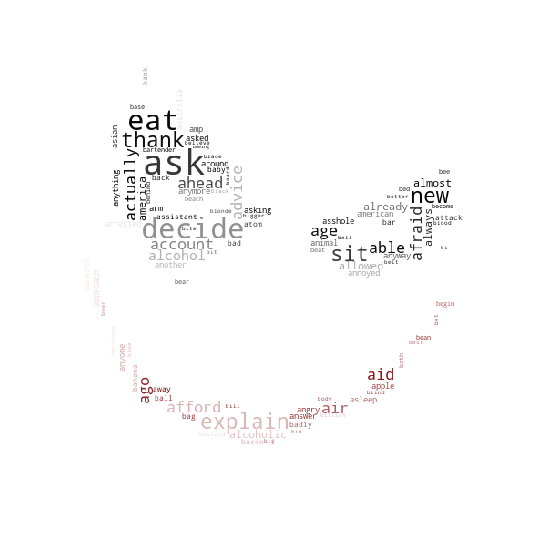

In [94]:
# Plotting word cloud
plt.subplots(figsize=(10,10)) # setting figure size
plt.axis('off') # turning off axis
plt.grid(b=None) # turning off grid

wc_jokes = WordCloud(background_color="white", 
               max_words=100, 
               mask=char_mask_jokes, 
               random_state=1).generate(jokes_top_words_str)

plt.imshow(wc_jokes.recolor(color_func=image_colors_jokes))

In [95]:
wc_jokes.to_file('./joker-word.png')

### Word Cloud featuring the keywords for r/askscience

In [96]:
cvec = CountVectorizer(max_df=0.2,
                       min_df=2,
                       max_features=1000
                      )

lemmatized_text_cvec = cvec.fit_transform(reddit_df_train[reddit_df_train['subreddit']==0]['lemmatized_text'])
askscience_top_words = cvec.get_feature_names()

In [97]:
askscience_top_words_str = ''
for word in askscience_top_words:
    askscience_top_words_str = askscience_top_words_str + ' ' + word

In [98]:
# Importing image to create a mask for word cloud
char_mask_askscience = np.array(Image.open("./test-tube-logo2.jpg"))
image_colors_askscience = ImageColorGenerator(char_mask_askscience)

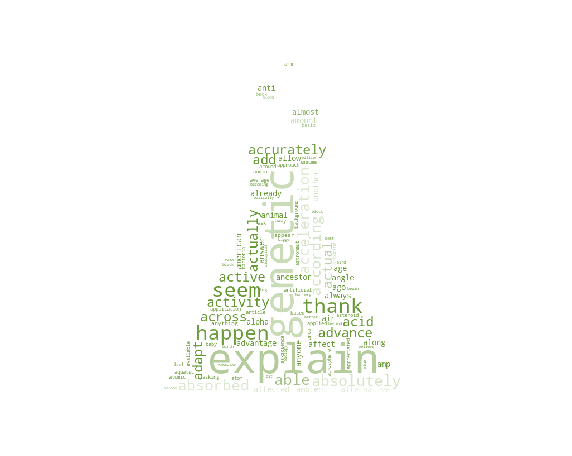

In [99]:
# Plotting word cloud
plt.subplots(figsize=(10,10)) # setting figure size
plt.axis('off') # turning off axis
plt.grid(b=None) # turning off grid

wc_askscience = WordCloud(background_color="white", 
               max_words=100, 
               mask=char_mask_askscience, 
               random_state=1).generate(askscience_top_words_str)

plt.imshow(wc_askscience.recolor(color_func=image_colors_askscience))

In [100]:
wc_askscience.to_file('./askscience-word.png')

## Moving Forward..

As this model is trained on words which users post on reddit, it is important to constantly re-train the model as the words and lingo that people use tend to change with time.

Future steps we can look into to improve our classification model would perhaps be to integrate the length of the titles and selftext into our model. As mentioned earlier, titles and selftext on r/askscience generally tend to be longer than those on r/Jokes.